# Self-labeling of Fully Mediating Representations by Graph Alignment

This notebook is made available as supporting material for the paper:
https://openreview.net/forum?id=XEw5Onu69uu

## 1. Download Indigo dataset

In [40]:
from ChemGrapher import download_file_from_google_drive
file_id ='16nAdDG78fnA3af7tWPhmg5MSjv1h5ZJS'
destination = './indigo_dataset.zip'
download_file_from_google_drive(file_id, destination)

In [23]:
from zipfile import ZipFile
import os 
with ZipFile('indigo_dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()
os.mkdir('dataset_indigo') 

## 2. Preprocess Indigo dataset images to correct resolution for ChemGrapher (1000x1000)

In [16]:
!python preprocess/preprocess_indigo_dataset.py --dataset_folder indigo_validation_set_examples/images --output_folder dataset_indigo --num_images 100

## 3. Try predicting SMILES (U->W) given one image from Indigo dataset using a pretrained ChemGrapher model

Let us first have a look at the input image.
Feel free to change the image filename to test with other images

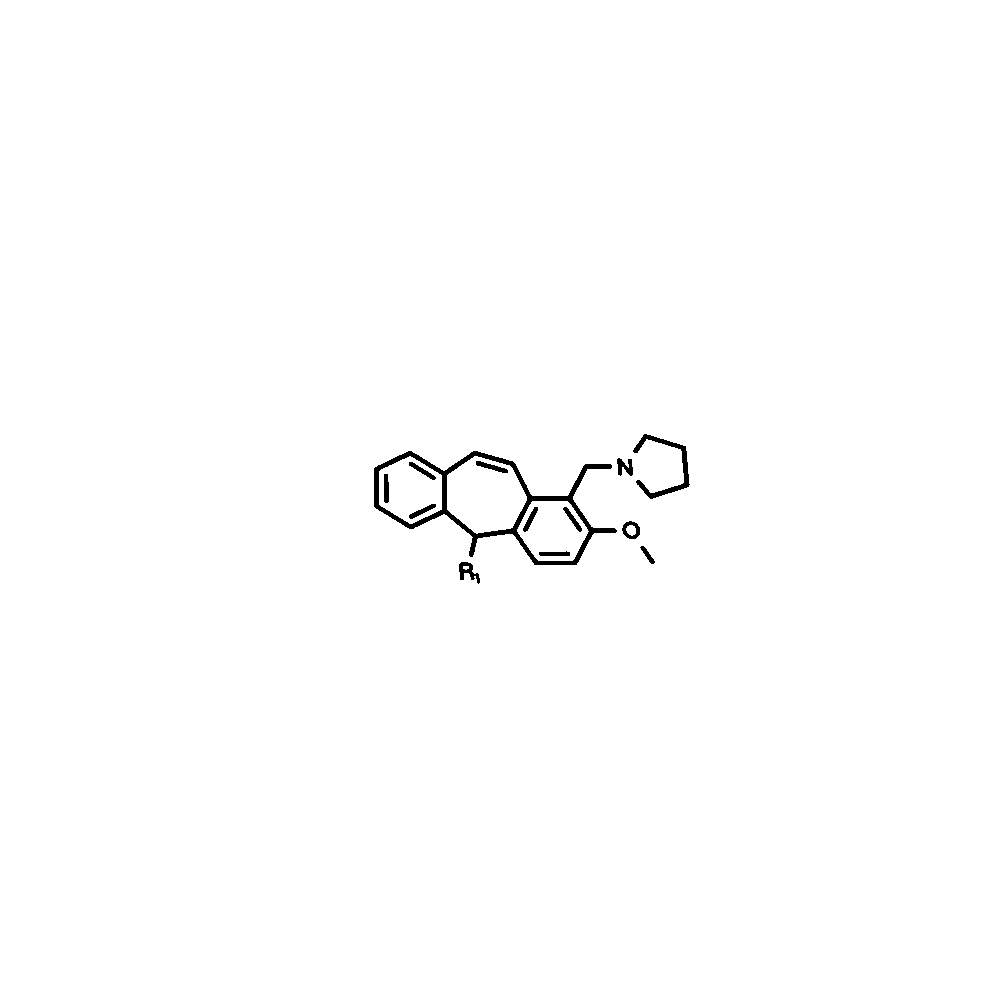

In [18]:
from IPython.display import Image
file_num=19
filename=f'dataset_indigo/{file_num}.png'
Image(filename=filename) 

In [122]:
smiles = !python run_scripts/predict.py --inputfile $filename --segnetwork pretrained_models/segmentation/pretrained_segmentation.SAV --clas_bond_network pretrained_models/bond_clas/pretrained_clas_bond.SAV --clas_atom_network pretrained_models/atom_clas/pretrained_clas_atom.SAV --clas_charge_network pretrained_models/charge_clas/pretrained_clas_charge.SAV

This is the resulting predicted SMILES:

In [123]:
smiles[4]

'COc1ccc2c(c1CN1CCCC1)C=Cc1ccccc1C2F'

Let us see how this predicted molecule looks like:

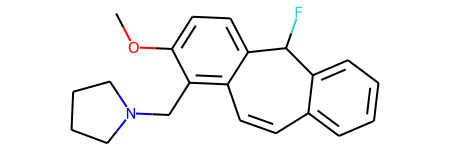

In [124]:
from rdkit import Chem
mol = Chem.MolFromSmiles(smiles[4])
mol

## 4. Predict U->V

The SMILES gives us the resulting graph (W) however without the planar embedding (V). When we have the planar embedding available we know which atom/edge prediction relates to which part in the original input image (U) and with this also where exactly the mistakes are made. So the next step is to use ChemGrapher to predict V given U.

In [3]:
planar = !python run_scripts/predict.py --type planar --inputfile $filename --segnetwork pretrained_models/segmentation/pretrained_segmentation.SAV --clas_bond_network pretrained_models/bond_clas/pretrained_clas_bond.SAV --clas_atom_network pretrained_models/atom_clas/pretrained_clas_atom.SAV --clas_charge_network pretrained_models/charge_clas/pretrained_clas_charge.SAV

Let us now visualize these predictions:

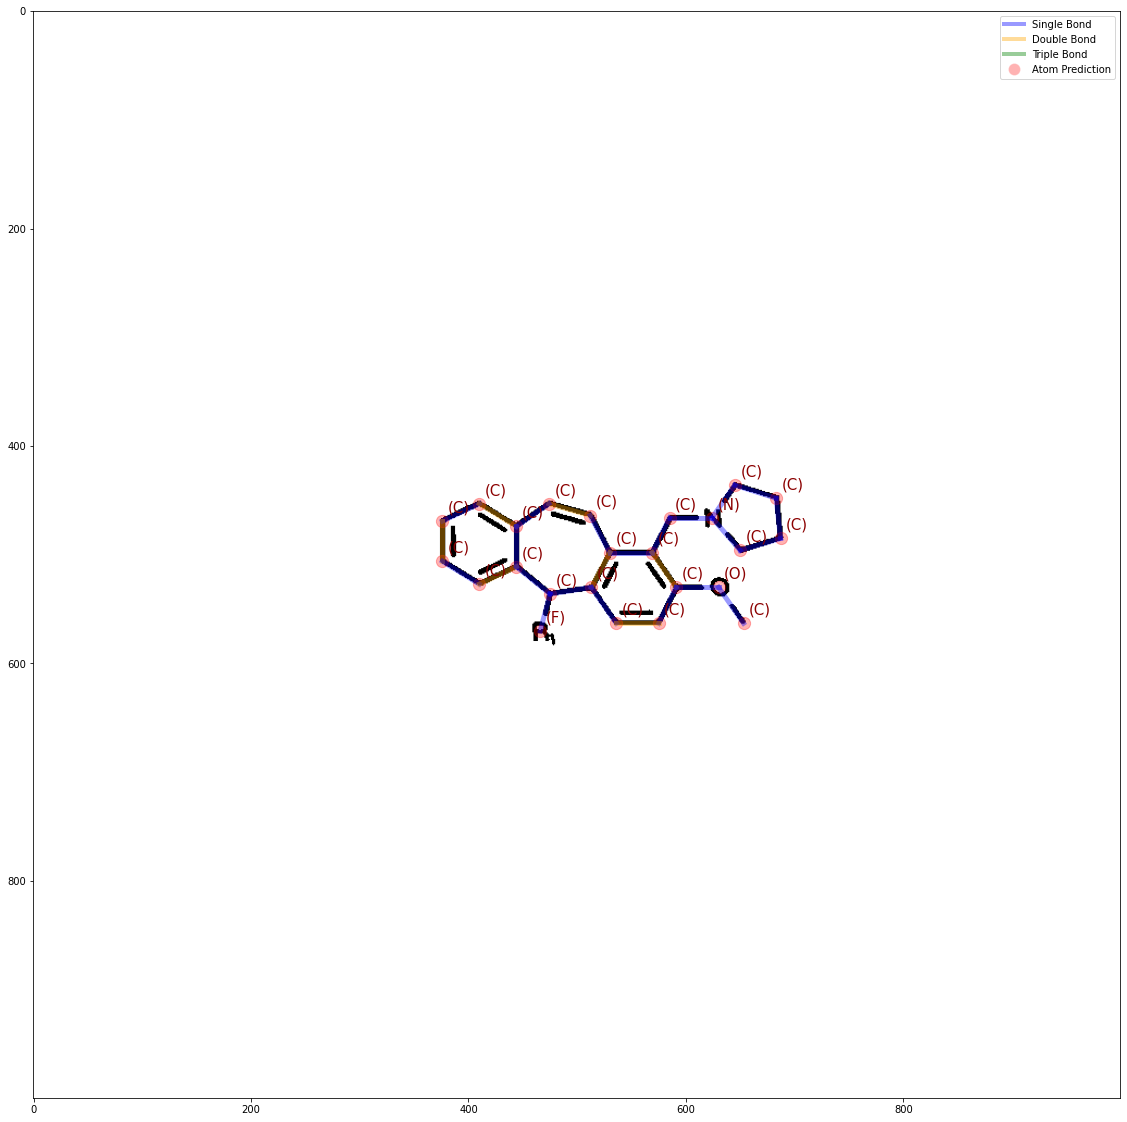

In [5]:
from ChemGrapher import visualize_planar
import ast
atom_list=ast.literal_eval(planar[4])
bond_list = planar[5].replace('array([','')
bond_list= bond_list.replace('])','')
bond_list=ast.literal_eval(bond_list)
visualize_planar(atom_list, bond_list,filename)

As we can see, the planar embedding is richer in information and gives a more detailed view of the graph predictions and how it embeds in the original image.

## 5. Relabel planar embedding by graph aligment

In [23]:
from ChemGrapher import alter_atom_graph
import ast
import pandas as pd
atom_list=ast.literal_eval(planar[4])
bond_list = planar[5].replace('array([','[')
bond_list= bond_list.replace('])',']')
bond_list=ast.literal_eval(bond_list)
df_smiles = pd.read_csv(f"dataset_indigo/smiles.csv")
original_smiles = df_smiles.loc[df_smiles['molid'] == file_num]
altered_atom_list = alter_atom_graph(atom_list, bond_list, original_smiles.iloc[0]['smiles'])

RDKit ERROR: [21:40:58] Explicit valence for atom # 0 H, 2, is greater than permitted
RDKit ERROR: [21:40:58] Explicit valence for atom # 0 F, 2, is greater than permitted
RDKit ERROR: [21:40:58] Explicit valence for atom # 1 H, 2, is greater than permitted
RDKit ERROR: [21:40:58] Explicit valence for atom # 1 F, 2, is greater than permitted
RDKit ERROR: [21:40:58] Explicit valence for atom # 2 H, 3, is greater than permitted
RDKit ERROR: [21:40:58] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [21:40:58] Explicit valence for atom # 2 F, 3, is greater than permitted
RDKit ERROR: [21:40:58] Explicit valence for atom # 3 H, 3, is greater than permitted
RDKit ERROR: [21:40:58] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [21:40:58] Explicit valence for atom # 3 F, 3, is greater than permitted
RDKit ERROR: [21:40:58] Explicit valence for atom # 4 H, 3, is greater than permitted
RDKit ERROR: [21:40:58] Explicit valence for atom # 4 

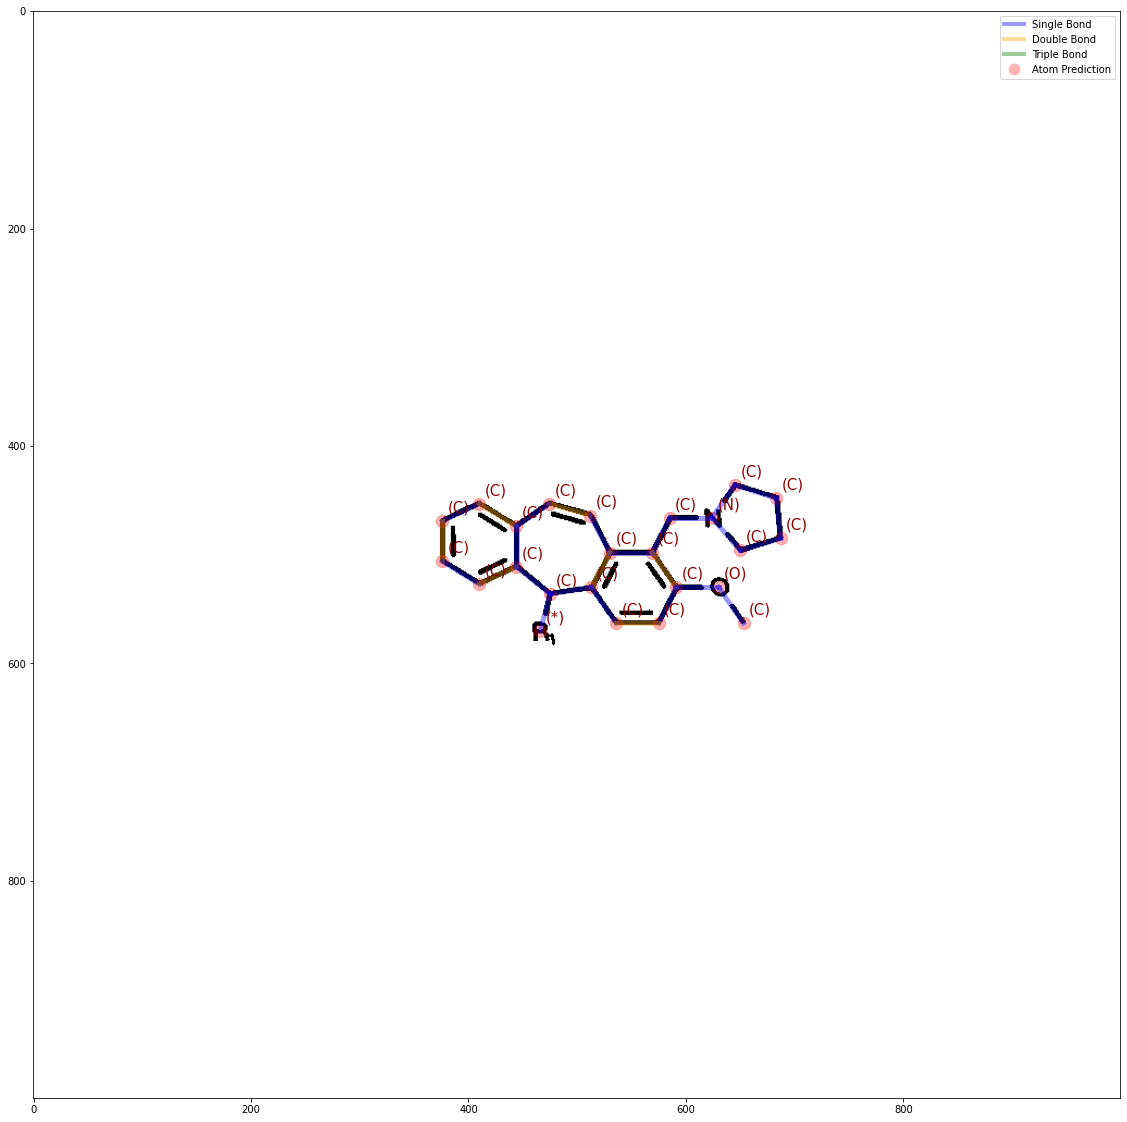

In [24]:
from ChemGrapher import visualize_planar
import ast
bond_list = planar[5].replace('array([','')
bond_list= bond_list.replace('])','')
bond_list=ast.literal_eval(bond_list)
if altered_atom_list is None:
    print('no relabeling was possible')
else:
    visualize_planar(altered_atom_list, bond_list,filename)

These corrected new rich labels can be used to retrain the model. In a next iteration using this new model the same process would be repeated.